In [1]:
# Cell 1: Imports
import os
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, DirectoryIterator
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import TensorBoard
import datetime


2024-05-02 23:16:42.656322: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 23:16:43.108688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 23:16:43.108744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 23:16:43.208627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 23:16:43.378069: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 23:16:43.381002: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Cell 2: Setup directories and parameters
base_dir = "/mnt/c/Users/frosty/Documents/CSI-Dissertation/images_faces"  
include_folders = ['1 (Alert)', '2 (Medium fatigue)', '3 (Asleep)']
img_width, img_height = 128, 128  
batch_size = 12


Class '1 (Alert)': 434 images
Class '2 (Medium fatigue)': 422 images
Class '3 (Asleep)': 393 images


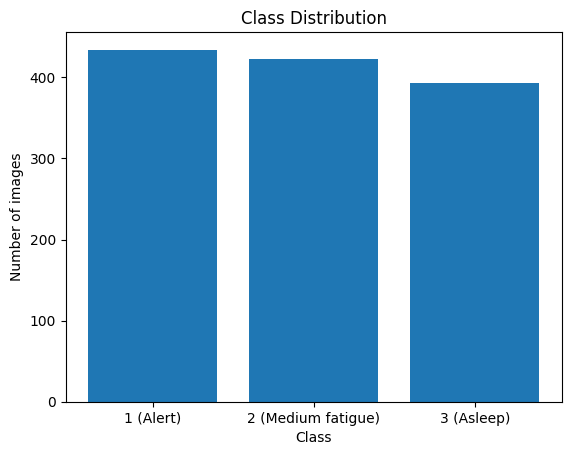

In [3]:
# Cell 3: Class distribution

class_names = ['1 (Alert)', '2 (Medium fatigue)', '3 (Asleep)']

# Initialize dictionary to hold the count of images in each class
class_distribution = {}

# Iterate over each class name and count the files
for class_name in class_names:
    class_folder = os.path.join(base_dir, class_name)
    class_count = len(os.listdir(class_folder))
    class_distribution[class_name] = class_count

# Print class distribution
for class_name, count in class_distribution.items():
    print(f"Class '{class_name}': {count} images")

#visualisation
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution')
plt.show()

In [4]:
# Cell 4: Function to load images from folders
def load_images_from_folders(subset_type):
    return datagen.flow_from_directory(
        base_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset_type,
        classes=include_folders
    )


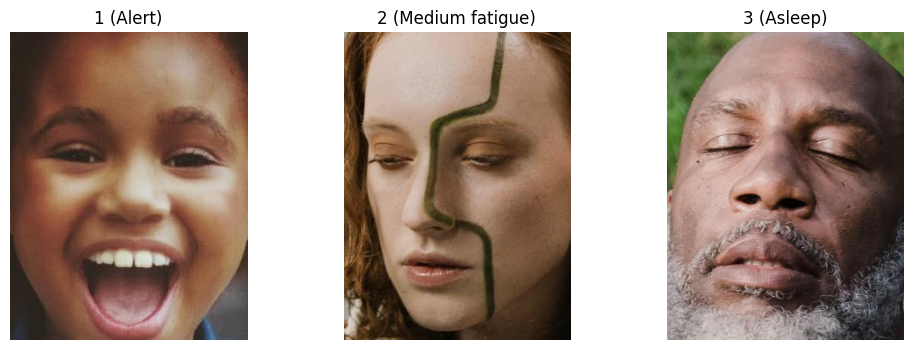

In [5]:
# Cell 5: Output sample images
def display_random_image_from_each_class(base_dir, include_folders):
    # Calculate the number of columns for subplots based on the number of folders
    num_folders = len(include_folders)
    
    # Set up the figure with a specified size and the calculated number of subplots
    plt.figure(figsize=(num_folders * 4, 4))  # Adjust the figure size as needed
    
    for index, folder in enumerate(include_folders, start=1):
        folder_path = os.path.join(base_dir, folder)
        images = os.listdir(folder_path)
        if images:
            random_image_name = random.choice(images)
            image_path = os.path.join(folder_path, random_image_name)
            img = load_img(image_path)  # Load the random image
            
            # Create a subplot for each folder's image
            plt.subplot(1, num_folders, index)
            plt.imshow(img)
            plt.title(folder)
            plt.axis('off')
    
    plt.show()  # Display all the images at once, horizontally

display_random_image_from_each_class(base_dir, include_folders)

In [6]:
# Cell 6: Defining Contrast
def adjust_contrast(image):
    # Adjust the contrast of the image
    return tf.image.adjust_contrast(image, 1.8)

In [7]:
# Cell 7: Initialise data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Reduced from 30 to 15
    width_shift_range=0.05,  # Reduced the range for shifting
    height_shift_range=0.05,  # Reduced the range for shifting
    shear_range=0.1,  # Reduced the shear range
    zoom_range=0.1,  # Reduced the zoom range
    horizontal_flip=False,  # Kept horizontal flip
    vertical_flip=False,  # Removed vertical flip
    fill_mode='reflect',  # Changed fill_mode to 'reflect'
    preprocessing_function=adjust_contrast,
    validation_split=0.3
)



In [8]:
# Cell 8: Load training and validation sets
train_generator = load_images_from_folders(subset_type='training')
validation_generator = load_images_from_folders(subset_type='validation')


Found 876 images belonging to 3 classes.
Found 373 images belonging to 3 classes.


2024-05-01 00:56:21.494066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 00:56:21.508828: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


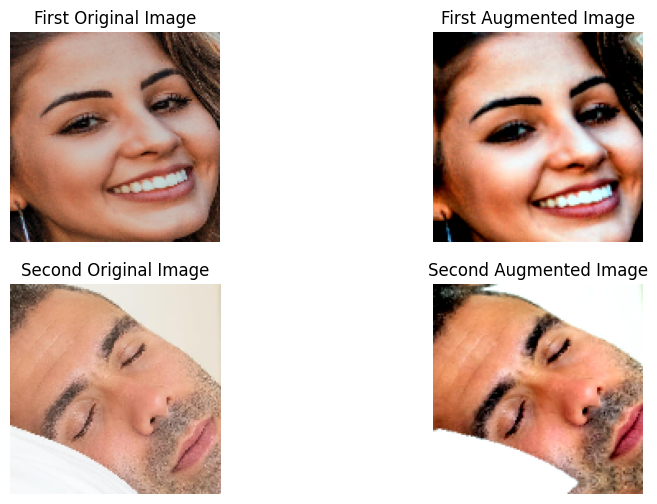

In [9]:
# Cell 9: Example and testing of data augmentation


# Load the first example image
first_image_path = '/mnt/c/Users/frosty/Documents/CSI-Dissertation/images_faces/1 (Alert)/15890.jpg'
first_img = load_img(first_image_path, target_size=(img_width, img_height))  # Adjust target_size if necessary
first_img_array = img_to_array(first_img)
first_img_array = np.expand_dims(first_img_array, axis=0)  # Create a batch

# Apply the augmentation to the first image
augmented_first_img = next(datagen.flow(first_img_array, batch_size=1))

# Load the second example image
second_image_path = '/mnt/c/Users/frosty/Documents/CSI-Dissertation/images_faces/3 (Asleep)/10384.jpg'
second_img = load_img(second_image_path, target_size=(img_width, img_height))  # Adjust target_size if necessary
second_img_array = img_to_array(second_img)
second_img_array = np.expand_dims(second_img_array, axis=0)  # Create a batch

# Apply the augmentation to the second image
augmented_second_img = next(datagen.flow(second_img_array, batch_size=1))

# Display the images
plt.figure(figsize=(10, 6))

# First image pair
plt.subplot(2, 2, 1)
plt.imshow(first_img)
plt.title('First Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(augmented_first_img[0])
plt.title('First Augmented Image')
plt.axis('off')

# Second image pair
plt.subplot(2, 2, 3)
plt.imshow(second_img)
plt.title('Second Original Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(augmented_second_img[0])
plt.title('Second Augmented Image')
plt.axis('off')


plt.show()


In [10]:
# Cell 10: Defining metrics for future use


class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


In [11]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 1e-1
    if epoch > 20:
        lr *= 1e-2
    if epoch > 30:
        lr *= 1e-3
    return lr


In [ ]:
# Cell 12 Model Creation

# Load  MobileNet model pre-trained on ImageNet data, excluding the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduced number of neurons
x = Dropout(0.8)(x)  # Using dropout to further combat overfitting 
predictions = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(x)  #3 classes

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

def print_filtered_model_summary(model):
    # Print a header for the summary
    print(f"{'Layer':<20} | {'Output Shape':<30} | {'Param #'}")
    print('-' * 75)
    
    # Iterate over the layers and print summary for layers with more than one parameter
    for layer in model.layers:
        if layer.count_params() > 1:  # Filter layers that have more than one parameter
            layer_name = layer.__class__.__name__
            output_shape = layer.output_shape
            params = layer.count_params()
            print(f"{layer_name:<20} | {str(output_shape):<30} | {params}")

# Assuming 'model' is already defined and compiled
print_filtered_model_summary(model)
plot_model(model, show_shapes=True, show_layer_names=True)


In [14]:
# Cell 14: Optimiser and model compilation 
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule(0))

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()]
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
              


In [15]:
# Cell 15: Defining early_stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,  # Number of epochs to wait after min has been hit. After this number of no improvement, training stops.
    restore_best_weights=True
)

In [16]:
# Set the directory for saving logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [17]:
from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath= '',
    save_weights_only=False,  # Set to True if you only want to save weights, not the full model
    monitor='val_accuracy',   # Metric to monitor
    mode='max',               # Save the model when the monitored metric is maximized
    save_best_only=True,      # Only save the model if 'val_accuracy' has improved
    verbose=1                 # Log a message whenever the model is saved
)

In [18]:
# Cell 8: Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs = 75,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint_callback, tensorboard_callback]  
     
)


Epoch 1/75
73/73 [==============================] - ETA: 0s - loss: 1.7363 - accuracy: 0.5400 - precision: 0.5535 - recall: 0.5194 - f1_score: 0.5359
Epoch 1: val_accuracy improved from -inf to 0.70161, saving model to 
INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


73/73 [==============================] - 27s 348ms/step - loss: 1.7363 - accuracy: 0.5400 - precision: 0.5535 - recall: 0.5194 - f1_score: 0.5359 - val_loss: 1.0926 - val_accuracy: 0.7016 - val_precision: 0.7284 - val_recall: 0.6344 - val_f1_score: 0.6782 - lr: 0.0010
Epoch 2/75
73/73 [==============================] - ETA: 0s - loss: 1.1250 - accuracy: 0.6621 - precision: 0.6970 - recall: 0.6301 - f1_score: 0.6619
Epoch 2: val_accuracy improved from 0.70161 to 0.71237, saving model to 
INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


73/73 [==============================] - 24s 329ms/step - loss: 1.1250 - accuracy: 0.6621 - precision: 0.6970 - recall: 0.6301 - f1_score: 0.6619 - val_loss: 0.9400 - val_accuracy: 0.7124 - val_precision: 0.7515 - val_recall: 0.6909 - val_f1_score: 0.7199 - lr: 0.0010
Epoch 3/75
73/73 [==============================] - ETA: 0s - loss: 1.0052 - accuracy: 0.6998 - precision: 0.7136 - recall: 0.6655 - f1_score: 0.6887
Epoch 3: val_accuracy improved from 0.71237 to 0.75806, saving model to 
INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


73/73 [==============================] - 24s 327ms/step - loss: 1.0052 - accuracy: 0.6998 - precision: 0.7136 - recall: 0.6655 - f1_score: 0.6887 - val_loss: 0.8510 - val_accuracy: 0.7581 - val_precision: 0.7797 - val_recall: 0.7419 - val_f1_score: 0.7603 - lr: 0.0010
Epoch 4/75
73/73 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.7100 - precision: 0.7326 - recall: 0.6975 - f1_score: 0.7146
Epoch 4: val_accuracy improved from 0.75806 to 0.76344, saving model to 
INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


73/73 [==============================] - 24s 328ms/step - loss: 0.9193 - accuracy: 0.7100 - precision: 0.7326 - recall: 0.6975 - f1_score: 0.7146 - val_loss: 0.8399 - val_accuracy: 0.7634 - val_precision: 0.7747 - val_recall: 0.7581 - val_f1_score: 0.7663 - lr: 0.0010
Epoch 5/75
73/73 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.7534 - precision: 0.7738 - recall: 0.7420 - f1_score: 0.7576
Epoch 5: val_accuracy did not improve from 0.76344
73/73 [==============================] - 19s 258ms/step - loss: 0.8244 - accuracy: 0.7534 - precision: 0.7738 - recall: 0.7420 - f1_score: 0.7576 - val_loss: 0.8645 - val_accuracy: 0.7473 - val_precision: 0.7479 - val_recall: 0.7258 - val_f1_score: 0.7367 - lr: 0.0010
Epoch 6/75
73/73 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.7568 - precision: 0.7764 - recall: 0.7374 - f1_score: 0.7564
Epoch 6: val_accuracy did not improve from 0.76344
73/73 [==============================] - 20s 269ms/step - lo

In [19]:
# Cell 9: Save the model
model.save('fatigue_detection_model.h5')


/home/frosty/MLing images/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'lr'])


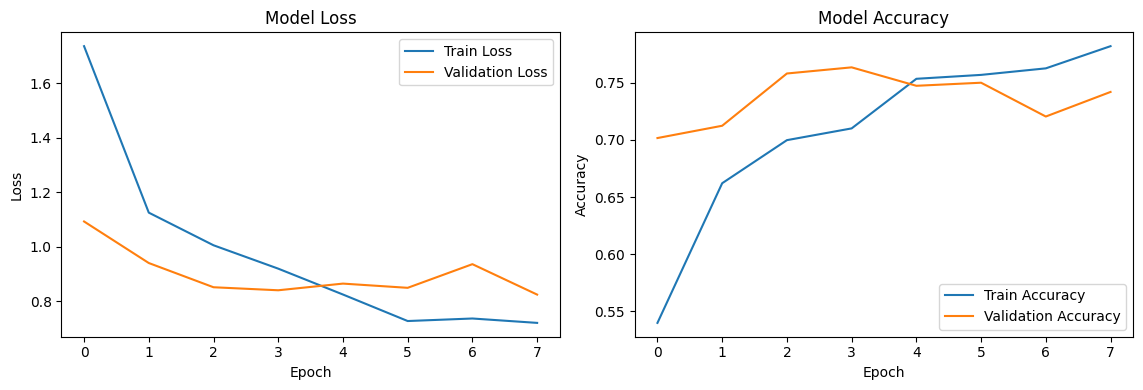

In [21]:
# Assuming you have 'precision' and 'recall' in your history object
plt.figure(figsize=(23, 4))

# Plot training & validation loss values
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

# Plot training & validation accuracy values
plt.subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()




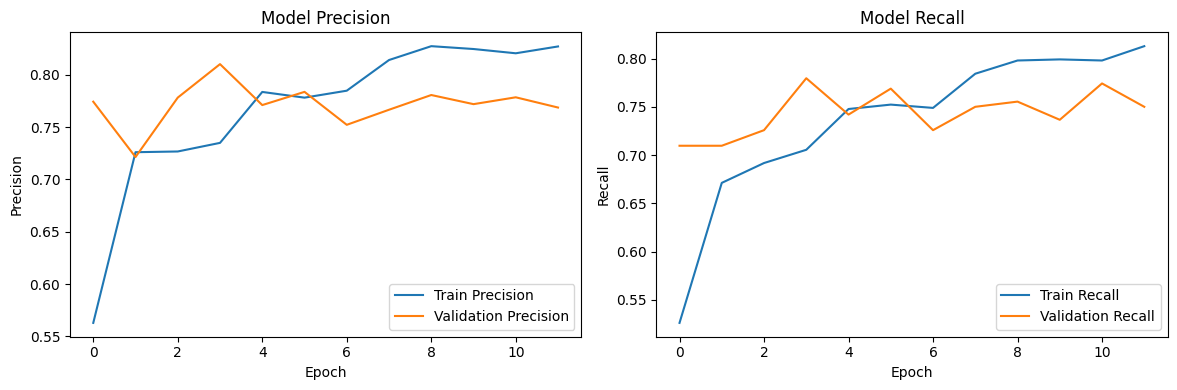

In [36]:
plt.figure(figsize=(23, 4))

# Plot training & validation precision values
plt.subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc="lower right")

# Plot training & validation recall values
plt.subplot(1, 4, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


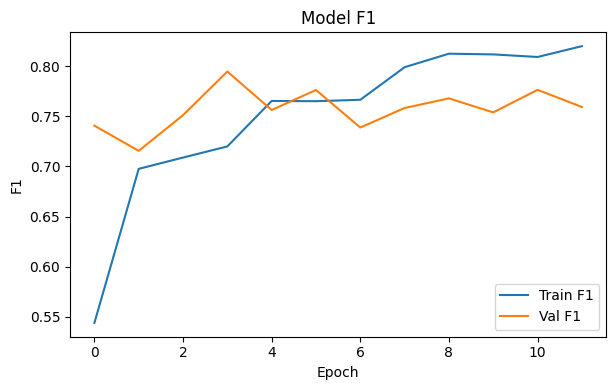

In [46]:
# Assuming you have 'precision' and 'recall' in your history object
plt.figure(figsize=(24, 4))
plt.subplot(1, 4, 4)
plt.plot(history.history['f1_score'], label='Train F1')
plt.plot(history.history['val_f1_score'], label='Val F1')
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

32/32 [==============================] - 6s 165ms/step


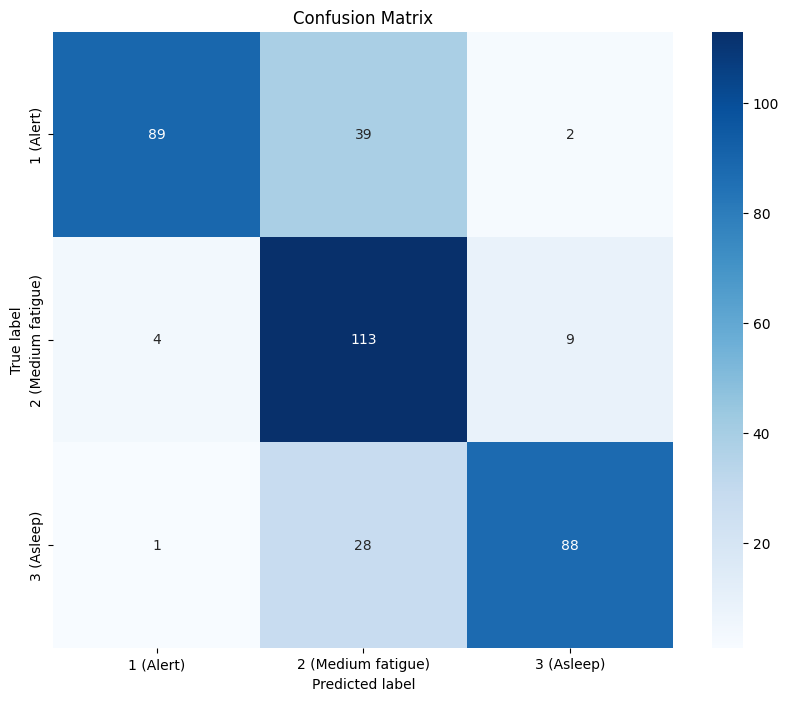

In [26]:

# Replace 'validation_generator' with your actual validation data generator
true_labels = np.array([])
for _ in range(len(validation_generator)):
    imgs, labels = next(validation_generator)
    true_labels = np.append(true_labels, np.argmax(labels, axis=1))

# Predicting on the entire validation set
predicted_labels = model.predict(validation_generator, steps=len(validation_generator))
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=include_folders, yticklabels=include_folders, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


32/32 [==============================] - 5s 165ms/step


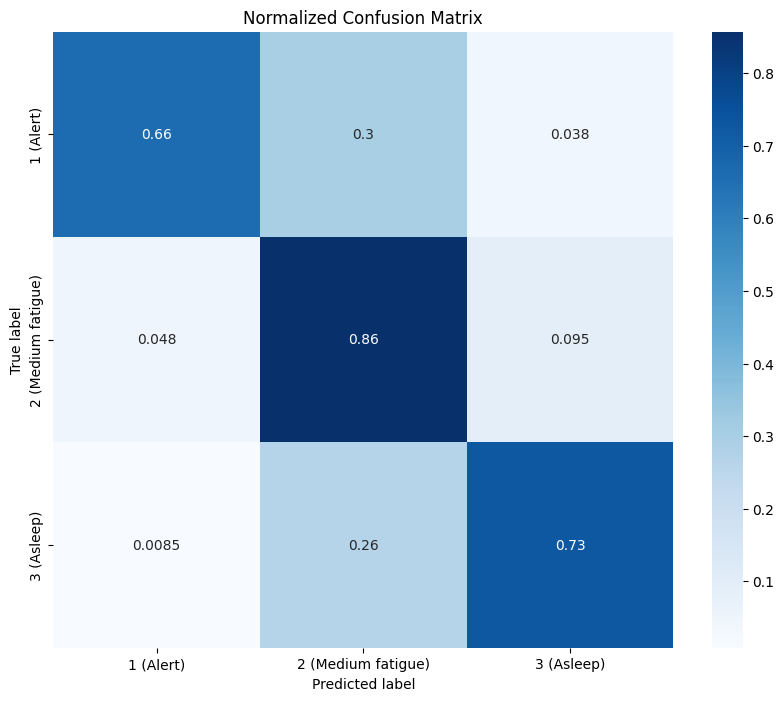

In [27]:



# Replace 'validation_generator' with your actual validation data generator
true_labels = np.array([])
for _ in range(len(validation_generator)):
    imgs, labels = next(validation_generator)
    true_labels = np.append(true_labels, np.argmax(labels, axis=1))

# Predicting on the entire validation set
predicted_labels = model.predict(validation_generator, steps=len(validation_generator))
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, xticklabels=include_folders, yticklabels=include_folders, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
